In [1]:
import sys
# sys.path.insert(0, '../GET')


from Models.FCWithEvidences import graph_based_semantic_structure
from Fitting.FittingFC import char_man_fitter_query_repr1
import time
import json
from interactions import ClassificationInteractions
import matchzoo as mz
from handlers import cls_load_data
import argparse
import random
import numpy as np
import torch
import torch_utils
import numpy as np
import os
import datetime
from handlers.output_handler_FC import FileHandlerFC
from Evaluation import mzEvaluator as evaluator
from setting_keywords import KeyWordSettings
from matchzoo.embedding import entity_embedding
from Models.BiDAF.wrapper import GGNN, GGNN_with_GSL, Linear
from thirdparty.two_branches_attention import *


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset="PolitiFact"
fixed_length_left=30
fixed_length_right=100
log="logs/testget"
loss_type="cross_entropy"
batch_size=32
num_folds=5
use_claim_source=1
use_article_source=1
path="formatted_data/declare/"
hidden_size=300
epochs=100
num_att_heads_for_words=3
num_att_heads_for_evds=1
gnn_window_size=3
lr=0.0001
gnn_dropout=0.2
seed=123456
gsl_rate=0.6
fixed_length_left_src_chars = 20
fixed_length_right_src_chars = 20
seed = 123456
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
preprocessor = mz.preprocessors.CharManPreprocessor(fixed_length_left = fixed_length_left,
                                                    fixed_length_right = fixed_length_right,
                                                    fixed_length_left_src = fixed_length_left_src_chars,
                                                    fixed_length_right_src = fixed_length_right_src_chars)

In [4]:
dataset="PolitiFact"
fixed_length_left=30
fixed_length_right=100
log="logs/get"
batch_size=32
gnn_window_size=3
fold_idx=0
if not os.path.exists(log):
      os.mkdir(log)
secondary_log_folder = os.path.join(log, "log_results_%s" % (dataset))
if not os.path.exists(secondary_log_folder):
  os.mkdir(secondary_log_folder)
secondary_log_folder = secondary_log_folder
root = os.path.join(os.path.join(path,dataset), "mapped_data")
tx = time.time()
kfold_dev_results, kfold_test_results = [], []
list_metrics = KeyWordSettings.CLS_METRICS
outfolder_per_fold = os.path.join(secondary_log_folder, "Fold_%s" % fold_idx)
if not os.path.exists(outfolder_per_fold):
    os.mkdir(outfolder_per_fold)
logfolder_result_per_fold = os.path.join(outfolder_per_fold, "result_%s.txt" % int(seed))
file_handler = FileHandlerFC()
file_handler.init_log_files(logfolder_result_per_fold)
# root ="/content/drive/MyDrive/GET/formatted_data/declare/Snopes/mapped_data"
# ------------------------------------------------------------------------------------
predict_pack = cls_load_data.load_data(root + "/%sfold" % num_folds,  'test_%sres' % 0, kfolds = num_folds)
train_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'train_%sres' % 0, kfolds = num_folds)
# predict_pack = cls_load_data.load_data(root + "/%sfold" % num_folds,  'testnew' , kfolds = num_folds)
# train_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'trainnew' , kfolds = num_folds)
valid_pack = cls_load_data.load_data(root, 'dev', kfolds = num_folds)

a = train_pack.left["text_left"].str.lower().str.split().apply(len).max()
b = valid_pack.left["text_left"].str.lower().str.split().apply(len).max()
c = predict_pack.left["text_left"].str.lower().str.split().apply(len).max()
max_query_length = max([a, b, c])
min_query_length = min([a, b, c])

a = train_pack.right["text_right"].str.lower().str.split().apply(len).max()
b = valid_pack.right["text_right"].str.lower().str.split().apply(len).max()
c = predict_pack.right["text_right"].str.lower().str.split().apply(len).max()
max_doc_length = max([a, b, c])
min_doc_length = min([a, b, c])

file_handler.myprint("Min query length, " + str(min_query_length) + " Min doc length " + str(min_doc_length))
file_handler.myprint("Max query length, " + str(max_query_length) + " Max doc length " + str(max_doc_length))
global additional_data
additional_data = {KeyWordSettings.OutputHandlerFactChecking: file_handler,
                    KeyWordSettings.GNN_Window: gnn_window_size}

print('parsing data')

train_processed = preprocessor.fit_transform(train_pack)  # This is a DataPack
valid_processed = preprocessor.transform(valid_pack)
predict_processed = preprocessor.transform(predict_pack)


train_interactions = ClassificationInteractions(train_processed, **additional_data)
valid_interactions = ClassificationInteractions(valid_processed, **additional_data)
predict_interactions = ClassificationInteractions(predict_processed, **additional_data)
file_handler.myprint('done extracting')
  

100%|██████████| 3108/3108 [00:00<00:00, 500475.94it/s]


Min query length, 23 Min doc length 100
Max query length, 25 Max doc length 100
parsing data


Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 2568/2568 [00:00<00:00, 7121.25it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 20980/20980 [00:10<00:00, 1912.82it/s]
Processing text_right with extend: 100%|██████████| 20980/20980 [00:00<00:00, 61300.58it/s]
Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 2568/2568 [00:00<00:00, 7237.86it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 20980/20980 [00:11<00:00, 1893.86it/s]
Processing text_right with transform: 100%|██████████| 3108/3108 [00:00<00:00, 109857.38it/s]
Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 356/356 [00:00<00:00, 6994.21it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval: 100%|██████████| 3108/3108 [00:01<00:00, 

Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id



/Users/namle/Desktop/GET/interactions.py:15: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
done extracting


In [5]:
print("Loading word embeddings......")
t1_emb = time.time()
term_index = preprocessor.context['vocab_unit'].state['term_index']
glove_embedding = mz.datasets.embeddings.load_glove_embedding_FC(dimension = 300,
                                                                  term_index = term_index, **additional_data)

embedding_matrix = glove_embedding.build_matrix(term_index)
entity_embs1 = entity_embedding.EntityEmbedding(128)
claim_src_embs_matrix = entity_embs1.build_matrix(preprocessor.context['claim_source_unit'].state['term_index'])

entity_embs2 = entity_embedding.EntityEmbedding(128)
article_src_embs_matrix = entity_embs2.build_matrix(preprocessor.context['article_source_unit'].state['term_index'])

t2_emb = time.time()
print("Time to load word embeddings......", (t2_emb - t1_emb))

Loading word embeddings......
Word hit: (25195, 32228) 78.17736130073229
Time to load word embeddings...... 3.1675171852111816


In [6]:
match_params = {}
match_params['embedding'] = embedding_matrix
match_params["num_classes"] = 2
match_params["fixed_length_right"] = 100
match_params["fixed_length_left"] = 30

# for claim source
match_params["use_claim_source"] = use_claim_source
match_params["claim_source_embeddings"] = claim_src_embs_matrix
# for article source
match_params["use_article_source"] = use_article_source
match_params["article_source_embeddings"] = article_src_embs_matrix
# multi-head attention
match_params["cuda"] = 0
match_params["num_att_heads_for_words"] = num_att_heads_for_words  # first level
match_params["num_att_heads_for_evds"] = num_att_heads_for_evds  # second level


match_params['dropout_gnn'] = 0.2
match_params["dropout_left"] = 0.2
match_params["dropout_right"] = 0.2
match_params["hidden_size"] = hidden_size

match_params["gsl_rate"] = 0.6

match_params["embedding_freeze"] = True
match_params["output_size"] = 2 # if args.dataset == "Snopes" else 3
match_model = graph_based_semantic_structure.Graph_basedSemantiStructure(match_params)
match_model.load_state_dict(torch.load("/Users/namle/Desktop/GET/saved_model_123456",map_location=torch.device('cpu')))
import datetime
from handlers.output_handler_FC import FileHandlerFC
loss_type = 'cross_entropy'
epochs = 100
batch_size = 32
lr = 0.001
early_stopping = 10
outfolder_per_fold = "logs/get/log_results_PolitiFact/Fold_10"
curr_date = datetime.datetime.now().timestamp()
fixed_num_evidences = 30
file_handler = FileHandlerFC()
seed = 123756
fit_model = char_man_fitter_query_repr1.CharManFitterQueryRepr1(net = match_model, loss = loss_type, n_iter = epochs,
                                                  batch_size = batch_size, learning_rate = lr,
                                                  early_stopping = early_stopping, use_cuda = 0,
                                                  logfolder = outfolder_per_fold, curr_date = curr_date,
                                                  fixed_num_evidences = fixed_num_evidences,
                                                  output_handler_fact_checking = file_handler, seed=seed,
                                                  output_size=match_params["output_size"],args="args")

In [7]:
def normalize_matrix(matrix):
    max_val = torch.max(matrix)
    min_val = torch.min(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

def adjacency_matrix_from_matrix(matrix, threshold):
    normalized_matrix = normalize_matrix(matrix)
    size = normalized_matrix.shape[0]
    adjacency_matrix = np.zeros((size, size), dtype=int)

    for i in range(size):
        for j in range(size):
            if normalized_matrix[i][j] >= threshold:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1  # Uncomment if the graph is undirected

    return adjacency_matrix

In [8]:
def calculate_energy(logit, T=1):
    energy = - T * torch.logsumexp(logit / T, dim=-1)
    return energy

def calculate_adjacency_matrix(output):
    A = output @ output.T
    return A

def create_adjacency_matrix(A, threshold=0.5):
    adjacency_graph = adjacency_matrix_from_matrix(A, threshold)
    return adjacency_graph

def propagate_labels(adjacency_graph, batch_labels):
    mask = np.random.randint(2, size=batch_labels.shape)
    Y_propagation = np.array(batch_labels * (1 - mask))
    score = adjacency_graph @ Y_propagation
    return score

In [29]:
size = 30
cuda = False
import interactions
import torch_utils as my_utils
energy_train_full = torch.tensor([])
energy_train_ind = torch.tensor([])
energy_train_ood  = torch.tensor([])
energy_test_full  = torch.tensor([])
energy_test_ind = torch.tensor([])
energy_test_ood = torch.tensor([])
energy_full = torch.tensor([])
prob_logit = torch.tensor([])
# interactions: interactions.ClassificationInteractions
query_ind_idx =[]
query_ood_idx = []
import gc


def get_energy():
  query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(train_interactions,fit_model.fixed_num_evidences)

  for i in range(pair_labels.shape[0]):
    if pair_labels[i] == 1:
        query_ind_idx.append(i)
    else:
        query_ood_idx.append(i)
  logits = torch.tensor([])
  outputs = torch.tensor([])
  E = torch.tensor([])
  with torch.no_grad():

    for (minibatch_num,
                  (batch_query, batch_query_content, batch_query_len, batch_query_sources, batch_query_chr_src,
                    batch_query_adj, batch_evd_docs, batch_evd_contents, batch_evd_lens, batch_evd_sources,
                    # i.e. claim source
                    batch_evd_cnt_each_query, batch_evd_chr_src, batch_labels, batch_evd_docs_adj)) \
                      in enumerate(my_utils.minibatch(query_ids, left_contents, left_lengths, query_sources,
                                                      query_char_sources, query_adj,
                                                      evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources,
                                                      evd_cnt_each_query, evd_char_sources, pair_labels, evd_docs_adj,
                                                      batch_size=32)):
        batch_query = my_utils.gpu(torch.from_numpy(batch_query), cuda)
        batch_query_content = my_utils.gpu(torch.from_numpy(batch_query_content), cuda)
        # batch_query_len = my_utils.gpu(torch.from_numpy(batch_query_len), self._use_cuda)
        batch_query_sources = my_utils.gpu(torch.from_numpy(batch_query_sources), cuda)
        batch_query_chr_src = my_utils.gpu(torch.from_numpy(batch_query_chr_src), cuda)
        batch_query_adj = my_utils.gpu(torch.from_numpy(batch_query_adj), cuda)

        batch_evd_docs = my_utils.gpu(torch.from_numpy(batch_evd_docs), cuda)
        batch_evd_contents = my_utils.gpu(torch.from_numpy(batch_evd_contents), cuda)
        # batch_evd_lens = my_utils.gpu(torch.from_numpy(batch_evd_lens), self._use_cuda)
        batch_evd_sources = my_utils.gpu(torch.from_numpy(batch_evd_sources), cuda)
        batch_evd_cnt_each_query = my_utils.gpu(torch.from_numpy(batch_evd_cnt_each_query), cuda)
        batch_evd_chr_src = my_utils.gpu(torch.from_numpy(batch_evd_chr_src), cuda)

        batch_labels = my_utils.gpu(torch.from_numpy(batch_labels), cuda)
        batch_evd_docs_adj = my_utils.gpu(torch.from_numpy(batch_evd_docs_adj), cuda)
        # total_pairs += self._batch_size * self.
        additional_data = {KeyWordSettings.EvidenceCountPerQuery: batch_evd_cnt_each_query,
                            KeyWordSettings.FCClass.QueryCharSource: batch_query_chr_src,
                            KeyWordSettings.FCClass.DocCharSource: batch_evd_chr_src,
                            KeyWordSettings.Query_Adj: batch_query_adj,
                            KeyWordSettings.Evd_Docs_Adj: batch_evd_docs_adj}
        n=30
        evd_count_per_query = batch_evd_cnt_each_query  # (B, )
        query_char_source = batch_query_chr_src
        doc_char_source = batch_evd_chr_src
        query_adj = batch_query_adj
        evd_docs_adj = batch_evd_docs_adj
        _, L = batch_query_content.size()
        batch_size = batch_query.size(0)
        # prunning at this step to remove padding\
        e_lens, e_conts, q_conts, q_lens, e_adj = [], [], [], [], []
        e_chr_src_conts = []
        expaned_labels = []
        for evd_cnt, q_cont, q_len, evd_lens, evd_doc_cont, evd_chr_src, label, evd_adj in \
                zip(evd_count_per_query, batch_query_content, batch_query_len,
                    batch_evd_lens, batch_evd_contents, doc_char_source, batch_labels, evd_docs_adj):
            evd_cnt = int(torch_utils.cpu(evd_cnt).detach().numpy())
            e_lens.extend(list(evd_lens[:evd_cnt]))
            e_conts.append(evd_doc_cont[:evd_cnt, :])  # stacking later
            e_adj.append(evd_adj[:evd_cnt])
            e_chr_src_conts.append(evd_chr_src[:evd_cnt, :])
            q_lens.extend([q_len] * evd_cnt)
            q_conts.append(q_cont.unsqueeze(0).expand(evd_cnt, L))
            expaned_labels.extend([int(torch_utils.cpu(label).detach().numpy())] * evd_cnt)
        # concat
        e_conts = torch.cat(e_conts, dim=0)  # (n1 + n2 + ..., R)
        e_chr_src_conts = torch.cat(e_chr_src_conts, dim=0)  # (n1 + n2 + ... , R)
        e_adj = torch.cat(e_adj, dim=0)     # (n1 + n2 + ..., R, R)
        e_lens = np.array(e_lens)  # (n1 + n2 + ..., )
        q_conts = torch.cat(q_conts, dim=0)  # (n1 + n2 + ..., R)
        q_lens = np.array(q_lens)
        assert q_conts.size(0) == q_lens.shape[0] == e_conts.size(0) == e_lens.shape[0]

        d_new_indices, d_old_indices = torch_utils.get_sorted_index_and_reverse_index(e_lens)
        e_lens = my_utils.gpu(torch.from_numpy(e_lens), cuda)
        x = batch_query_len
        q_new_indices, q_restoring_indices = torch_utils.get_sorted_index_and_reverse_index(x)
        x = my_utils.gpu(torch.from_numpy(x), cuda)
        # query_lens = my_utils.gpu(torch.from_numpy(query_lens), self._use_cuda)

        additional_paramters = {
            KeyWordSettings.Query_lens: x,  # 每一个query长度
            KeyWordSettings.Doc_lens: batch_evd_lens,
            KeyWordSettings.DocLensIndices: (d_new_indices, d_old_indices, e_lens),
            KeyWordSettings.QueryLensIndices: (q_new_indices, q_restoring_indices, x),
            KeyWordSettings.QuerySources: batch_query_sources,
            KeyWordSettings.DocSources: batch_evd_sources,
            KeyWordSettings.TempLabel: batch_labels,
            KeyWordSettings.DocContentNoPaddingEvidence: e_conts,
            KeyWordSettings.QueryContentNoPaddingEvidence: q_conts,
            KeyWordSettings.EvidenceCountPerQuery: evd_count_per_query,
            KeyWordSettings.FCClass.QueryCharSource: query_char_source,  # (B, 1, L)
            KeyWordSettings.FCClass.DocCharSource: e_chr_src_conts,
            KeyWordSettings.FIXED_NUM_EVIDENCES: n,
            KeyWordSettings.Query_Adj: query_adj,
            KeyWordSettings.Evd_Docs_Adj: e_adj                       # flatten->(n1 + n2 ..., R, R)
        }
        query_repr = fit_model._net._generate_query_repr_gnn(batch_query_content, **additional_paramters)
        logit = match_model.predict(batch_query_content, batch_evd_contents, **additional_paramters)
        energy = calculate_energy(logit, 1)
        E = torch.cat((E, energy), dim=0)
        
        # Combine the score with the logit
        
        logits = torch.cat((logits,logit),dim = 0)
        
  return logits,E
logits,energy_train = get_energy()

# prob_logit = torch.cat((prob_logit,logits),dim = 0)
# energy_full = torch.cat((energy_full, energy_train), dim=0)

In [28]:
energy_predict = energy_train
logits_predict = logits

In [30]:
logits_train = logits

torch.Size([644])

In [27]:
logits.size()

torch.Size([644, 2])

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

In [19]:
def plot_kde(data, x_label, title):
  kde_obj = kde.gaussian_kde(data)

  x_grid = np.linspace(data.min(), data.max(), 400)
  density = kde_obj(x_grid)

  plt.plot(x_grid, density, label='KDE')

  plt.xlabel(x_label)
  plt.ylabel('Density')
  plt.title(title)
  plt.grid(True)
  plt.show()

/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_37399/198493470.py:1: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])
/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_37399/198493470.py:6: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])


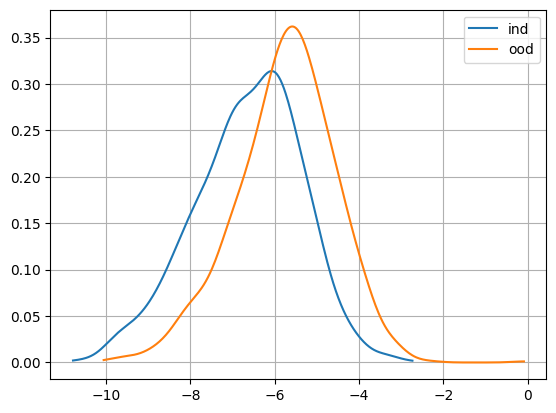

In [20]:

kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])

x_ind = np.linspace(energy_train.detach().numpy()[query_ind_idx].min(), energy_train.detach().numpy()[query_ind_idx].max(), 400)
density_ind = kde_obj_ind(x_ind)
plt.plot(x_ind, density_ind, label='ind')
kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])

x_ood = np.linspace(energy_train.detach().numpy()[query_ood_idx].min(), energy_train.detach().numpy()[query_ood_idx].max(), 400)

density_ood = kde_obj_ood(x_ood)

plt.plot(x_ood, density_ood, label='ood')

# Set labels and title.
# plt.xlabel(x_label)
# plt.ylabel('Density')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

In [43]:
query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(train_interactions,fit_model.fixed_num_evidences)

In [44]:
Y_train = pair_labels

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
energy_predict.size()


torch.Size([644])

In [47]:
logits_predict = np.array(logits_predict)

In [48]:
logits_train = np.array(logits_train)

In [58]:
energy_train= np.array(energy_train).reshape(-1,1)

In [59]:
energy_predict = np.array(energy_predict).reshape(-1,1)

In [41]:
Y_predict = pair_labels

In [45]:
Y_train.shape

(2568,)

In [56]:
logits_train.shape

(2568, 2)

In [60]:
energy_train.shape

(2568, 1)

In [61]:
X_train = np.concatenate((logits_train,energy_train),axis=-1)

In [62]:
X_predict = np.concatenate((logits_predict,energy_predict),axis=-1)

In [63]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [64]:
clf.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [65]:
y_valid = clf.predict(X_predict)

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
accuracy = accuracy_score(Y_predict, y_valid)
print("Accuracy:", accuracy)

Accuracy: 0.5419254658385093
